# Requirement 3: two extensions for pricing

### Imports

In [18]:
import numpy as np
import matplotlib.pyplot as plt

### Define the environment
non-stationary environment for the pricing problem
- Days are partitioned in intervals
- In each interval the demand curve is different
- The demand curve + noise specifies how many buyers will buy for every price
depending on the current interval

Build a pricing strategy using the discretization of the prices p ∈ [0, 1] and sliding-window

Total Reward: 75128.7345631872
Selected Prices: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02040816326530612, 0.0, 0.0, 0.02040816326530612, 0.0, 0.0, 0.02040816326530612, 0.02040816326530612, 0.02040816326530612, 0.1020408163265306, 0.04081632653061224, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02040816326530612, 0.02040816326530612, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02040816326530612, 0.02040816326530612, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

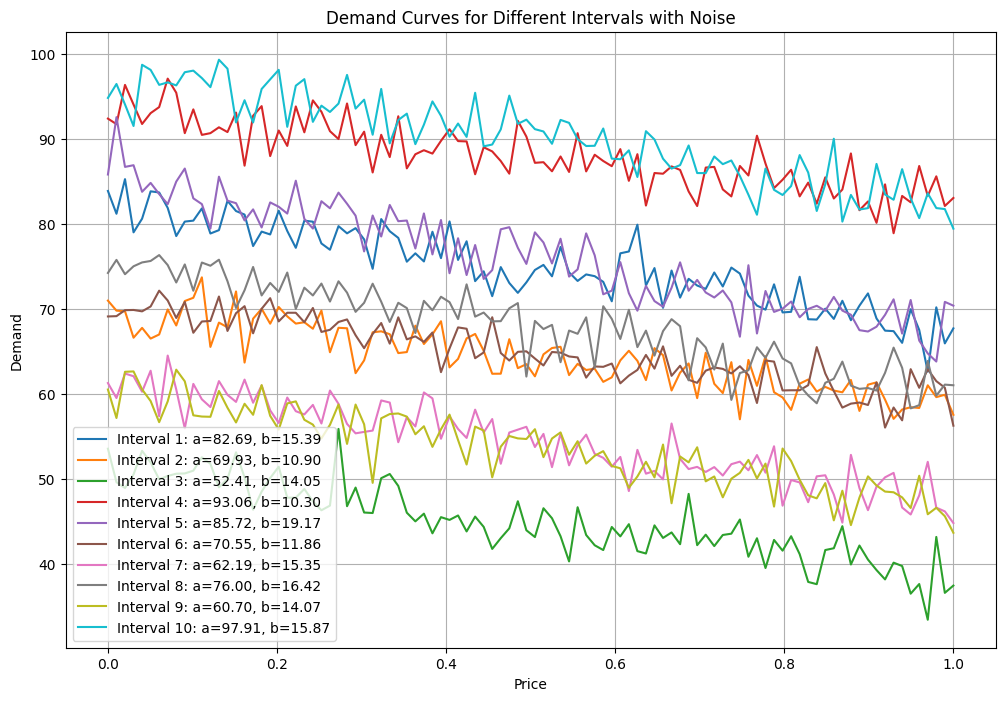

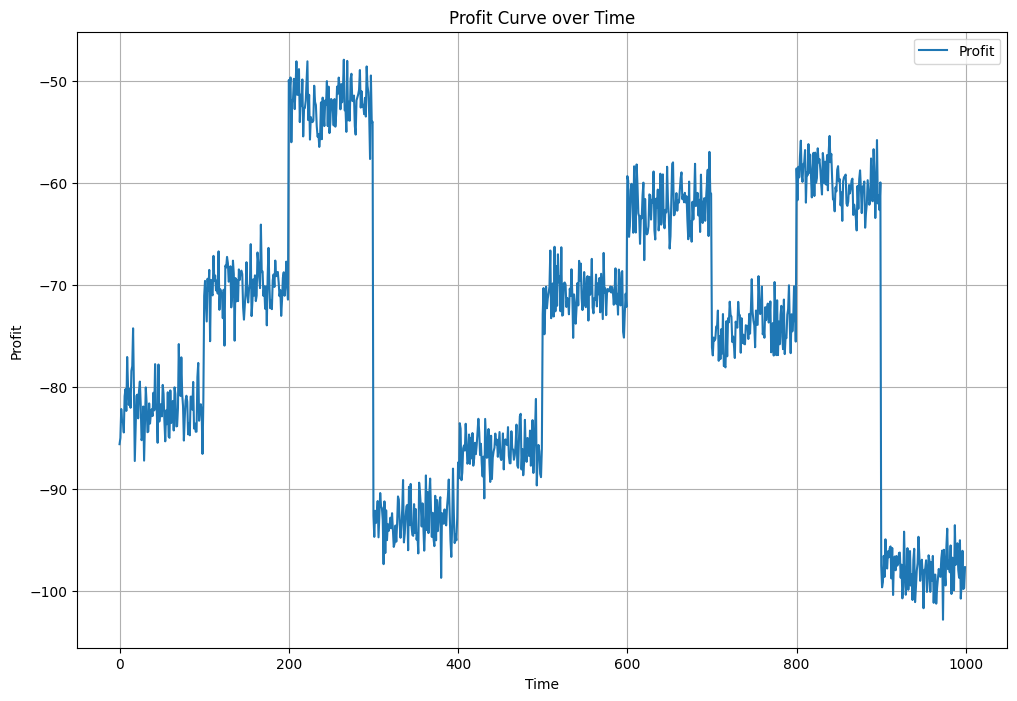

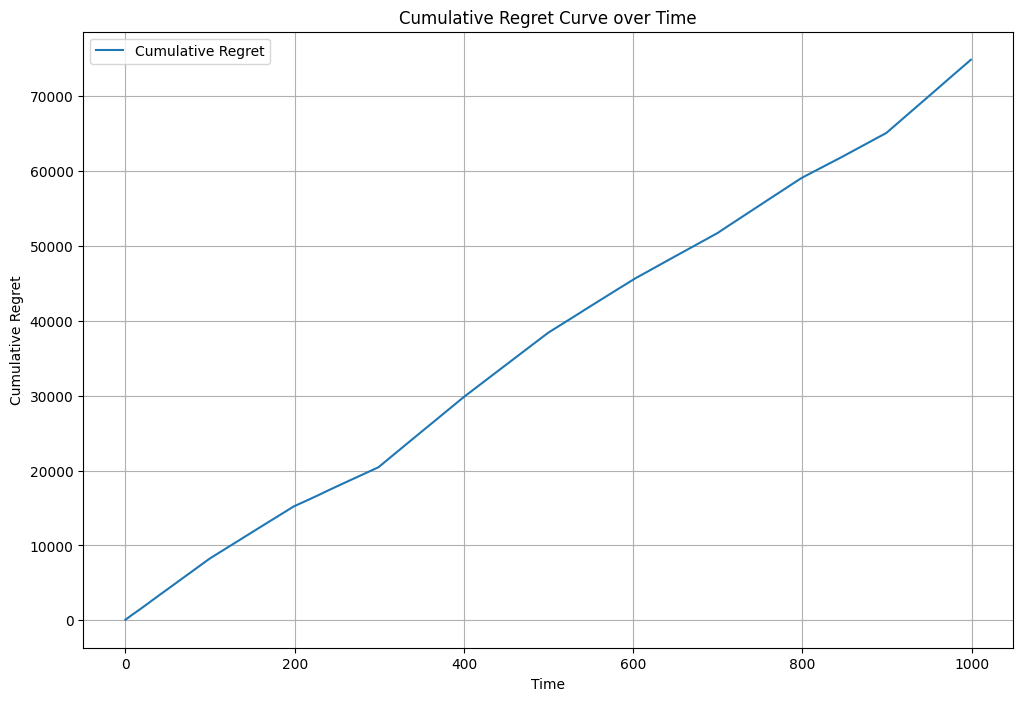

In [19]:
class NonStationaryPricing:
    def __init__(self, T, K, n, W, noise_std=5, cost=1):
        self.T = T
        self.K = K
        self.n = n
        self.W = W
        self.prices = np.linspace(0, 1, n)
        self.demand_params = self._generate_demand_params()
        self.rewards = np.zeros((T, n))
        self.counts = np.zeros((T, n))
        self.noise_std = noise_std  # Standard deviation of the Gaussian noise
        self.cost = cost  # Cost of producing each good
        self.profits = np.zeros(T)  # To store the profit at each time step
        self.regret = np.zeros(T)  # To store the regret at each time step

    def _generate_demand_params(self):
        # Generate different demand curve parameters for each interval
        a_k = np.random.uniform(50, 100, self.K)
        b_k = np.random.uniform(10, 20, self.K)
        return list(zip(a_k, b_k))

    def demand_curve(self, k, p):
        a_k, b_k = self.demand_params[k]
        demand = a_k - b_k * p
        noise = np.random.normal(0, self.noise_std)
        return demand + noise

    def get_interval(self, t):
        return t * self.K // self.T

    def simulate(self):
        for t in range(self.T):
            k = self.get_interval(t)
            for i, p in enumerate(self.prices):
                self.rewards[t, i] = self.demand_curve(k, p)
                self.counts[t, i] += 1

    def calculate_optimal_rewards(self):
        self.optimal_rewards = np.zeros(self.T)
        for t in range(self.T):
            k = self.get_interval(t)
            optimal_reward = -np.inf
            for p in self.prices:
                reward = (p - self.cost) * (self.demand_params[k][0] - self.demand_params[k][1] * p)
                if reward > optimal_reward:
                    optimal_reward = reward
            self.optimal_rewards[t] = optimal_reward

    def ucb1_sliding_window(self):
        total_reward = 0
        selected_prices = []
        for t in range(self.T):
            k = self.get_interval(t)
            ucb_values = np.zeros(self.n)
            for i, p in enumerate(self.prices):
                if t < self.W:
                    mu = np.mean(self.rewards[:t+1, i])
                    n_t = np.sum(self.counts[:t+1, i])
                else:
                    mu = np.mean(self.rewards[t-self.W+1:t+1, i])
                    n_t = np.sum(self.counts[t-self.W+1:t+1, i])
                ucb_values[i] = mu + np.sqrt(2 * np.log(t+1) / (n_t + 1))
            best_price_idx = np.argmax(ucb_values)
            selected_price = self.prices[best_price_idx]
            selected_prices.append(selected_price)
            reward = self.demand_curve(k, selected_price)
            profit = (selected_price - self.cost) * reward
            self.profits[t] = profit
            total_reward += reward
            self.rewards[t, best_price_idx] = reward
            self.counts[t, best_price_idx] += 1
            self.regret[t] = self.optimal_rewards[t] - profit
        return selected_prices, total_reward

# Parameters
T = 1000  # Time horizon
K = 10  # Number of intervals
n = 50  # Number of discrete prices
W = 100  # Sliding window size
noise_std = 2  # Reduced noise standard deviation
cost = 1  # Cost of producing each good

pricing = NonStationaryPricing(T, K, n, W, noise_std, cost)
pricing.simulate()
pricing.calculate_optimal_rewards()
selected_prices, total_reward = pricing.ucb1_sliding_window()

print(f"Total Reward: {total_reward}")
print(f"Selected Prices: {selected_prices}")

def plot_demand_curves(pricing):
    plt.figure(figsize=(12, 8))
    for k in range(pricing.K):
        a_k, b_k = pricing.demand_params[k]
        prices = np.linspace(0, 1, 100)
        demands = [a_k - b_k * p + np.random.normal(0, pricing.noise_std) for p in prices]
        plt.plot(prices, demands, label=f'Interval {k+1}: a={a_k:.2f}, b={b_k:.2f}')
    plt.xlabel('Price')
    plt.ylabel('Demand')
    plt.title('Demand Curves for Different Intervals with Noise')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_profit_curve(pricing):
    plt.figure(figsize=(12, 8))
    plt.plot(range(pricing.T), pricing.profits, label='Profit')
    plt.xlabel('Time')
    plt.ylabel('Profit')
    plt.title('Profit Curve over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_regret_curve(pricing):
    cumulative_regret = np.cumsum(pricing.regret)
    plt.figure(figsize=(12, 8))
    plt.plot(range(pricing.T), cumulative_regret, label='Cumulative Regret')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Regret')
    plt.title('Cumulative Regret Curve over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot demand curves
plot_demand_curves(pricing)

# Plot profit curve
plot_profit_curve(pricing)

# Plot regret curve
plot_regret_curve(pricing)


### CUSUM
Build a pricing strategy using the discretization of the prices p ∈ [0, 1] and CUSUM

Total Reward: 70179.11609221941
Selected Prices: [0.02040816326530612, 0.061224489795918366, 0.0, 0.0, 0.04081632653061224, 0.061224489795918366, 0.061224489795918366, 0.061224489795918366, 0.061224489795918366, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02040816326530612, 0.02040816326530612, 0.1020408163265306, 0.1020408163265306, 0.02040816326530612, 0.02040816326530612, 0.02040816326530612, 0.02040816326530612, 0.02040816326530612, 0.02040816326530612, 0.02040816326530612, 0.02040816326530612, 0.02040816326530612, 0.0, 0.04081632653061224, 0.04081632653061224, 0.08163265306122448, 0.08163265306122448, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08163265306122448, 0.04081632653061224, 0.04081632653061224, 0.04081632653061224, 0.04081632653061224, 0.061224489795918366, 0.061224489795918366, 0.061224489795918366, 0.061224489795918366, 0.061224489795918366, 0.061224489795918366, 0.061224489795918366, 0.061224489795918366, 0.061224489795918

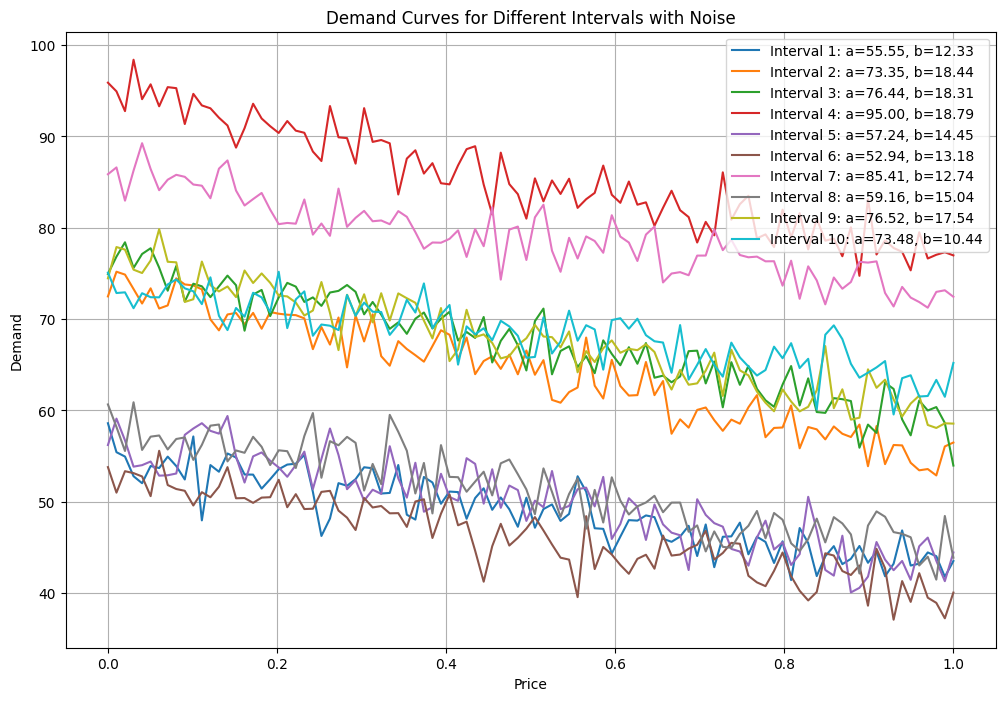

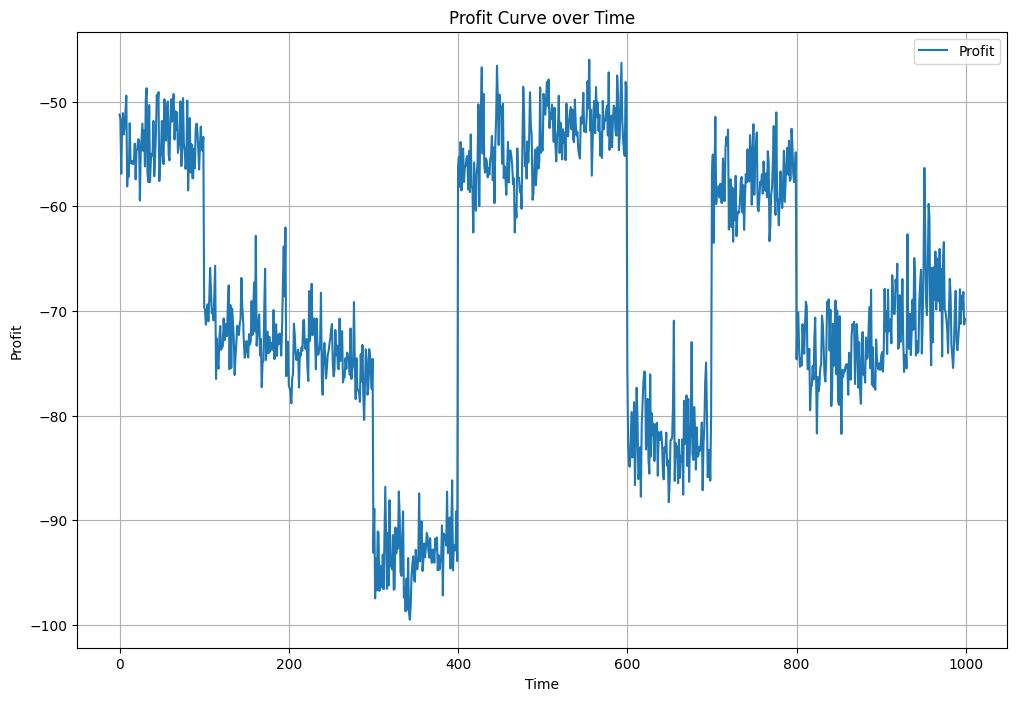

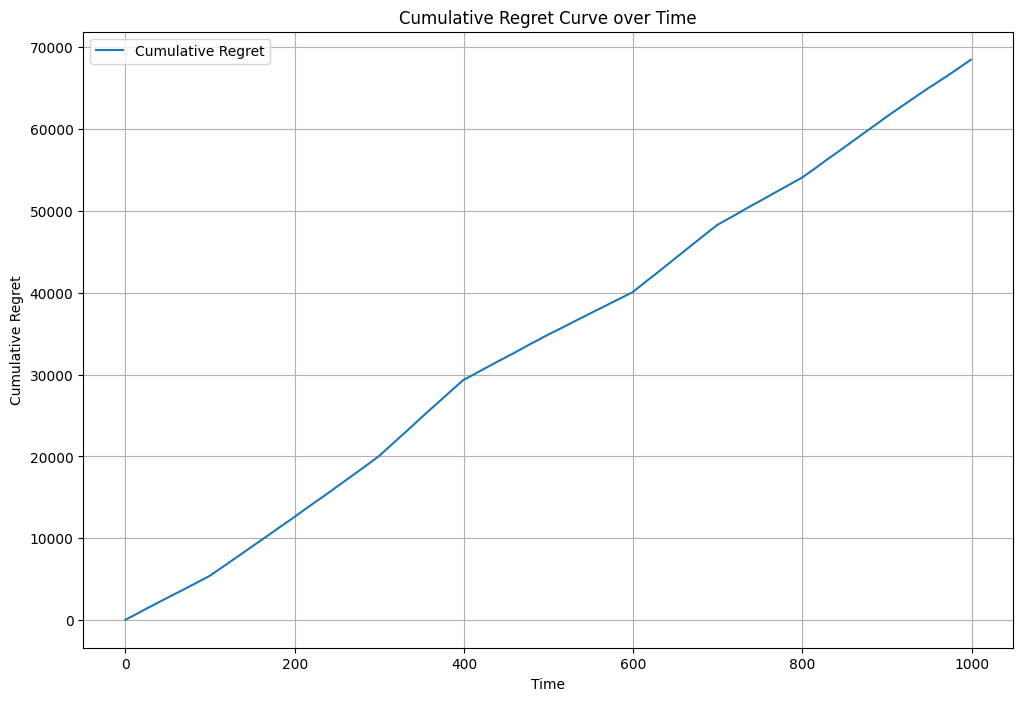

In [20]:
class NonStationaryPricing:
    def __init__(self, T, K, n, W, noise_std=5, cost=1, M=30, epsilon=0.05, h=10):
        """
        Initialize the NonStationaryPricing class.
        
        Parameters:
        - T: Time horizon
        - K: Number of intervals
        - n: Number of discrete prices
        - W: Sliding window size
        - noise_std: Standard deviation of the Gaussian noise
        - cost: Cost of producing each good
        - M: Number of samples for the estimation phase
        - epsilon: Threshold for detecting change
        - h: Threshold for CUSUM
        """
        self.T = T
        self.K = K
        self.n = n
        self.W = W
        self.prices = np.linspace(0, 1, n)  # Discretized prices
        self.demand_params = self._generate_demand_params()  # Demand parameters for each interval
        self.rewards = np.zeros((T, n))  # Rewards matrix
        self.counts = np.zeros((T, n))  # Counts of each price being chosen
        self.noise_std = noise_std  # Standard deviation of the Gaussian noise
        self.cost = cost  # Cost of producing each good
        self.profits = np.zeros(T)  # To store the profit at each time step
        self.regret = np.zeros(T)  # To store the regret at each time step
        self.M = M  # Number of samples for the estimation phase
        self.epsilon = epsilon  # Threshold for detecting change
        self.h = h  # Threshold for CUSUM

    def _generate_demand_params(self):
        """
        Generate different demand curve parameters for each interval.
        Returns:
        - List of tuples containing (a_k, b_k) for each interval
        """
        a_k = np.random.uniform(50, 100, self.K)  # Demand curve intercepts
        b_k = np.random.uniform(10, 20, self.K)  # Demand curve slopes
        return list(zip(a_k, b_k))

    def demand_curve(self, k, p):
        """
        Calculate the demand for a given price in a given interval.
        
        Parameters:
        - k: Interval index
        - p: Price
        
        Returns:
        - Demand with added Gaussian noise
        """
        a_k, b_k = self.demand_params[k]
        demand = a_k - b_k * p
        noise = np.random.normal(0, self.noise_std)
        return demand + noise

    def get_interval(self, t):
        """
        Determine the interval for a given time step.
        
        Parameters:
        - t: Time step
        
        Returns:
        - Interval index
        """
        return t * self.K // self.T

    def simulate(self):
        """
        Simulate the environment to generate rewards for each price at each time step.
        """
        for t in range(self.T):
            k = self.get_interval(t)
            for i, p in enumerate(self.prices):
                self.rewards[t, i] = self.demand_curve(k, p)
                self.counts[t, i] += 1

    def calculate_optimal_rewards(self):
        """
        Calculate the optimal rewards for each time step.
        """
        self.optimal_rewards = np.zeros(self.T)
        for t in range(self.T):
            k = self.get_interval(t)
            optimal_reward = -np.inf
            for p in self.prices:
                reward = (p - self.cost) * (self.demand_params[k][0] - self.demand_params[k][1] * p)
                if reward > optimal_reward:
                    optimal_reward = reward
            self.optimal_rewards[t] = optimal_reward

    def cusum_pricing(self):
        """
        Implement the CUSUM algorithm combined with UCB1 for pricing.
        
        Returns:
        - selected_prices: List of prices selected at each time step
        - total_reward: Total reward accumulated
        """
        total_reward = 0
        selected_prices = []
        # CUSUM variables
        g_pos = np.zeros(self.n)
        g_neg = np.zeros(self.n)
        tau = np.zeros(self.n)
        mu_hat = np.zeros(self.n)
        W = self.W  # Initial window size
        for t in range(self.T):
            k = self.get_interval(t)
            ucb_values = np.zeros(self.n)
            for i, p in enumerate(self.prices):
                if t < W:
                    mu = np.mean(self.rewards[:t+1, i])
                    n_t = np.sum(self.counts[:t+1, i])
                else:
                    mu = np.mean(self.rewards[t-W+1:t+1, i])
                    n_t = np.sum(self.counts[t-W+1:t+1, i])
                
                if t > self.M:
                    reward = self.rewards[t, i]
                    s_pos = reward - mu_hat[i] - self.epsilon
                    s_neg = -reward + mu_hat[i] - self.epsilon
                    g_pos[i] = max(0, g_pos[i] + s_pos)
                    g_neg[i] = max(0, g_neg[i] + s_neg)
                    if g_pos[i] > self.h or g_neg[i] > self.h:
                        tau[i] = t
                        g_pos[i] = 0
                        g_neg[i] = 0
                        mu_hat[i] = np.mean(self.rewards[t-self.M:t, i])
                        W = min(max(W // 2, 10), self.W)  # Dynamically adjust the window size
                
                ucb_values[i] = mu + np.sqrt(2 * np.log(t+1) / (n_t + 1))
            best_price_idx = np.argmax(ucb_values)
            selected_price = self.prices[best_price_idx]
            selected_prices.append(selected_price)
            reward = self.demand_curve(k, selected_price)
            profit = (selected_price - self.cost) * reward
            self.profits[t] = profit
            total_reward += reward
            self.rewards[t, best_price_idx] = reward
            self.counts[t, best_price_idx] += 1
            self.regret[t] = self.optimal_rewards[t] - profit
        return selected_prices, total_reward

# Parameters
T = 1000  # Time horizon
K = 10  # Number of intervals
n = 50  # Number of discrete prices
W = 100  # Sliding window size
noise_std = 2  # Reduced noise standard deviation
cost = 1  # Cost of producing each good
M = 30  # Number of samples for estimation phase
epsilon = 0.05  # Threshold for detecting change
h = 10  # Threshold for CUSUM

# Initialize and run the simulation
pricing = NonStationaryPricing(T, K, n, W, noise_std, cost, M, epsilon, h)
pricing.simulate()
pricing.calculate_optimal_rewards()
selected_prices, total_reward = pricing.cusum_pricing()

print(f"Total Reward: {total_reward}")
print(f"Selected Prices: {selected_prices}")

def plot_demand_curves(pricing):
    """
    Plot the demand curves for different intervals.
    """
    plt.figure(figsize=(12, 8))
    for k in range(pricing.K):
        a_k, b_k = pricing.demand_params[k]
        prices = np.linspace(0, 1, 100)
        demands = [a_k - b_k * p + np.random.normal(0, pricing.noise_std) for p in prices]
        plt.plot(prices, demands, label=f'Interval {k+1}: a={a_k:.2f}, b={b_k:.2f}')
    plt.xlabel('Price')
    plt.ylabel('Demand')
    plt.title('Demand Curves for Different Intervals with Noise')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_profit_curve(pricing):
    """
    Plot the profit curve over time.
    """
    plt.figure(figsize=(12, 8))
    plt.plot(range(pricing.T), pricing.profits, label='Profit')
    plt.xlabel('Time')
    plt.ylabel('Profit')
    plt.title('Profit Curve over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_regret_curve(pricing):
    """
    Plot the cumulative regret curve over time.
    """
    cumulative_regret = np.cumsum(pricing.regret)
    plt.figure(figsize=(12, 8))
    plt.plot(range(pricing.T), cumulative_regret, label='Cumulative Regret')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Regret')
    plt.title('Cumulative Regret Curve over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot demand curves
plot_demand_curves(pricing)

# Plot profit curve
plot_profit_curve(pricing)

# Plot regret curve
plot_regret_curve(pricing)
